In [ ]:
VGG-19 Model

In [1]:
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
#Setting some inital parameters
height, width = 224, 224
batch_size=64

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/ANN_Test/brain_tumor_dataset"


In [6]:
cd /content/drive/MyDrive/ANN_Test/brain_tumor_dataset

/content/drive/MyDrive/ANN_Test/brain_tumor_dataset


In [7]:
data_dir = '/content/drive/MyDrive/ANN_Test/brain_tumor_dataset'

In [8]:
def image_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=batch_size,
            subset="training",
            #color_mode = 'grayscale',
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    val_ds = datagen.flow_from_directory(
              data_dir,
              subset="validation",
              #seed=123,
              #color_mode = 'grayscale',
              class_mode='binary',
              target_size=(height, width),
              batch_size=batch_size,
            classes={'no': 0., 'yes': 1.}
            )
    return train_ds, val_ds

train_ds, val_ds = image_generator(height,width)

total_image = np.concatenate([train_ds.labels,val_ds.labels])
print('\n\n',{'No_brain_tumor_cases':len(np.where(total_image==0)[0]),
      'brain_tumor_cases':len(np.where(total_image==1)[0])})

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


 {'No_brain_tumor_cases': 98, 'brain_tumor_cases': 155}


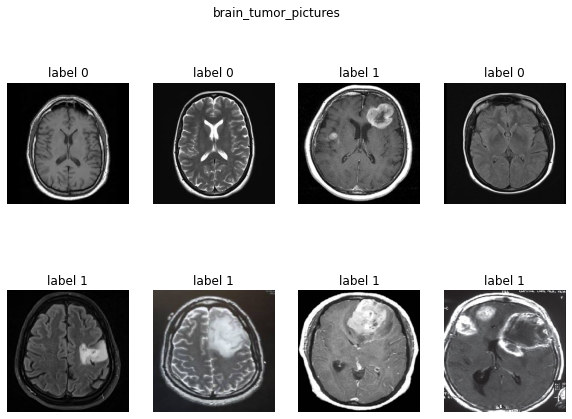

In [9]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("brain_tumor_pictures")
for k in range(8):
    images, labels = train_ds.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

In [10]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
model_vgg19.add(tf.keras.layers.Flatten())

model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg19.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_vgg19.summary()


80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [11]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_vgg19.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 6.2864 - acc: 0.5074 
Epoch 1: acc improved from -inf to 0.50739, saving model to model/vgg19_best.h5
4/4 [==============================] - 167s 42s/step - loss: 6.2864 - acc: 0.5074 - val_loss: 11.9838 - val_acc: 0.6200
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 9.6078 - acc: 0.6158  
Epoch 2: acc improved from 0.50739 to 0.61576, saving model to model/vgg19_best.h5
4/4 [==============================] - 171s 55s/step - loss: 9.6078 - acc: 0.6158 - val_loss: 2.1429 - val_acc: 0.7600
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 3.9577 - acc: 0.5665 
Epoch 3: acc did not improve from 0.61576
4/4 [==============================] - 155s 49s/step - loss: 3.9577 - acc: 0.5665 - val_loss: 2.7170 - val_acc: 0.7000
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 2.2882 - acc: 0.7882 
Epoch 4: acc improved from 0.61576 to 0.78818, saving model to model/vgg19_best.h5
4

In [12]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 32s 32s/step - loss: 0.6571 - acc: 0.8400


,Train,Val
Loss,0.007561,0.657144
Acc,1.000000,0.840000


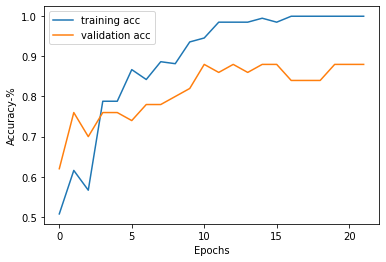

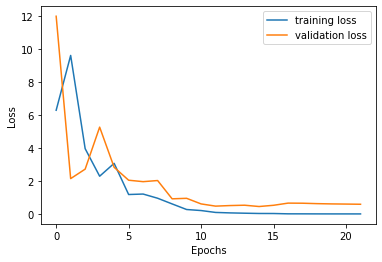

In [13]:
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

Adding Image Augmentation


In [14]:
def augmentataion_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=30,
            horizontal_flip=True,
            brightness_range=(0.5, 1.0)
            )
    aug_train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=64,
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    return aug_train_ds

aug_train_ds = augmentataion_generator(height,width)

Found 253 images belonging to 2 classes.


In [15]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,reduce_lr]

history = model_vgg19.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 0.5142 - acc: 0.8340 
Epoch 1: acc did not improve from 1.00000
4/4 [==============================] - 210s 55s/step - loss: 0.5142 - acc: 0.8340 - val_loss: 0.7327 - val_acc: 0.8200 - lr: 0.0100
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 0.6817 - acc: 0.8182 
Epoch 2: acc did not improve from 1.00000
4/4 [==============================] - 205s 55s/step - loss: 0.6817 - acc: 0.8182 - val_loss: 0.4129 - val_acc: 0.9200 - lr: 0.0100
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 0.7677 - acc: 0.8103 
Epoch 3: acc did not improve from 1.00000
4/4 [==============================] - 196s 52s/step - loss: 0.7677 - acc: 0.8103 - val_loss: 0.2116 - val_acc: 0.9200 - lr: 0.0100
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 0.4555 - acc: 0.8498 
Epoch 4: acc did not improve from 1.00000
4/4 [==============================] - 208s 55s/step - loss: 0.4555 - acc: 0.8498 - 

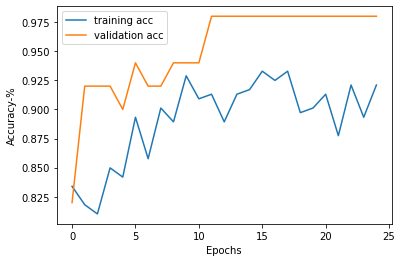

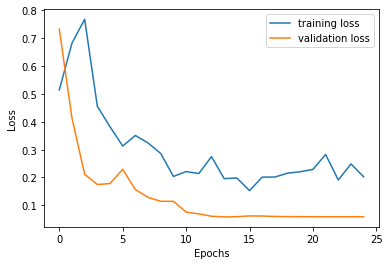

In [16]:
plot_learning_curve(history)


Final VGG19 model results

In [17]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 31s 31s/step - loss: 0.0591 - acc: 0.9800


,Train,Val
Loss,0.009001,0.059137
Acc,1.000000,0.980000


In [18]:
ypred_val = model_vgg19.predict(val_ds[0][0])
ypred_val = np.array([1 if x > 0.5 else 0 for x in ypred_val])
y_val = val_ds[0][-1]

print(confusion_matrix(y_val, ypred_val))
print('\n',classification_report(ypred_val,y_val))

[[18  1]
 [ 0 31]]

               precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.97      0.98        32

    accuracy                           0.98        50
   macro avg       0.97      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



INCEPTION V3 Model

In [19]:
height = 299
width = 299

train_ds, val_ds = image_generator(height,width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(
                    loss='binary_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_inceptionv3.summary()

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 21,933,857
Trainable params: 131,073
Non-trainable params: 21,802,784
_________________________________________________________________


In [20]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_inceptionv3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 0.5579 - acc: 0.7438 
Epoch 1: acc improved from -inf to 0.74384, saving model to model/inceptionv3_best.h5
4/4 [==============================] - 62s 15s/step - loss: 0.5579 - acc: 0.7438 - val_loss: 0.8685 - val_acc: 0.9200
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 0.5244 - acc: 0.9064 
Epoch 2: acc improved from 0.74384 to 0.90640, saving model to model/inceptionv3_best.h5
4/4 [==============================] - 55s 14s/step - loss: 0.5244 - acc: 0.9064 - val_loss: 1.2913 - val_acc: 0.8400
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 0.1783 - acc: 0.9557 
Epoch 3: acc improved from 0.90640 to 0.95567, saving model to model/inceptionv3_best.h5
4/4 [==============================] - 66s 18s/step - loss: 0.1783 - acc: 0.9557 - val_loss: 0.7534 - val_acc: 0.9000
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 0.0560 - acc: 0.9852
Epoch 4: acc improved from 0.95

In [21]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 10s 10s/step - loss: 1.0707 - acc: 0.9000


,Train,Val
Loss,0.029037,1.070669
Acc,0.985222,0.900000


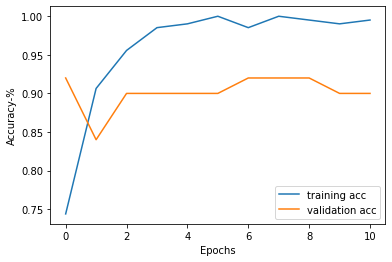

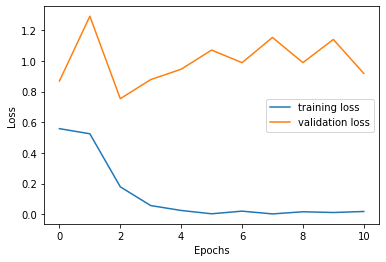

In [22]:
plot_learning_curve(history)

Adding Image augmentation

In [23]:
aug_train_ds = augmentataion_generator(height,width)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=3, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model_inceptionv3.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25, 
        #shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Found 253 images belonging to 2 classes.
Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 2.9143 - acc: 0.7628 
Epoch 1: acc did not improve from 1.00000
4/4 [==============================] - 69s 18s/step - loss: 2.9143 - acc: 0.7628 - val_loss: 3.5547 - val_acc: 0.6800 - lr: 0.0010
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 1.8292 - acc: 0.8300 
Epoch 2: acc did not improve from 1.00000
4/4 [==============================] - 66s 17s/step - loss: 1.8292 - acc: 0.8300 - val_loss: 0.8302 - val_acc: 0.9200 - lr: 0.0010
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 1.8457 - acc: 0.8063 
Epoch 3: acc did not improve from 1.00000
4/4 [==============================] - 72s 18s/step - loss: 1.8457 - acc: 0.8063 - val_loss: 2.7617 - val_acc: 0.7400 - lr: 0.0010
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 1.1601 - acc: 0.8538 
Epoch 4: acc did not improve from 1.00000
4/4 [==============================] - 69s 18s

Final InceptionV3 model results

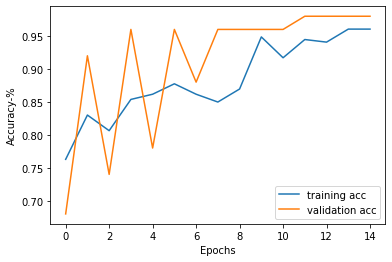

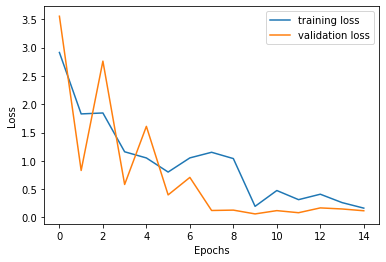

In [24]:
plot_learning_curve(history)

In [25]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 10s 10s/step - loss: 0.0624 - acc: 0.9600


,Train,Val
Loss,0.006600,0.062392
Acc,0.995074,0.960000


In [26]:
ypred = model_inceptionv3.predict(val_ds[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = val_ds[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
print('\nClassification_report:\n',classification_report(ypred,ytest))

Confusion_Matrix:
 [[19  0]
 [ 2 29]]

Classification_report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.94      1.00      0.97        29

    accuracy                           0.96        50
   macro avg       0.97      0.95      0.96        50
weighted avg       0.96      0.96      0.96        50



CNN Using Keras

In [28]:
from sklearn.preprocessing import OneHotEncoder 
encoder = OneHotEncoder()
encoder.fit([[0], [1]]) 

OneHotEncoder()

In [29]:
data = []
paths = []
result = []

In [30]:
for r, d, f in os.walk('/content/drive/MyDrive/ANN_Test/brain_tumor_dataset/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

In [32]:
from PIL import Image
for path in paths:
    img = Image.open(path)
    img = img.resize((125,125))
    img = np.array(img)
    if(img.shape == (125,125,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

In [33]:
paths = []
for r, d, f in os.walk('/content/drive/MyDrive/ANN_Test/brain_tumor_dataset/no'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

In [34]:
for path in paths:
    img = Image.open(path)
    img = img.resize((125,125))
    img = np.array(img)
    if(img.shape == (125,125,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

In [35]:
result = np.array(result)
result = result.reshape(139,2)

In [51]:
import os
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 

In [52]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

In [53]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(125, 125, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))

In [54]:
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

In [55]:
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", optimizer='Adamax')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 125, 125, 32)      416       
                                                                 
 conv2d_99 (Conv2D)          (None, 125, 125, 32)      4128      
                                                                 
 batch_normalization_96 (Bat  (None, 125, 125, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 62, 62, 32)        0         
                                                                 
 conv2d_100 (Conv2D)         (None, 62, 62, 64)       

In [56]:
y_train.shape

(111, 2)

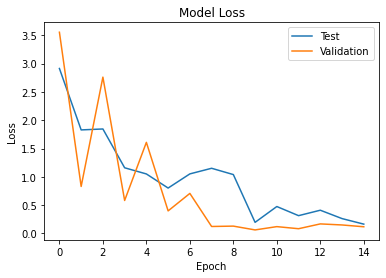

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

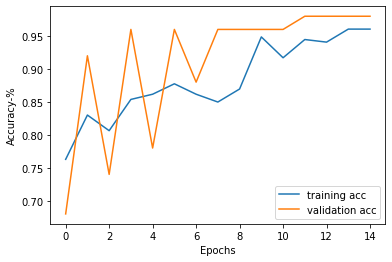

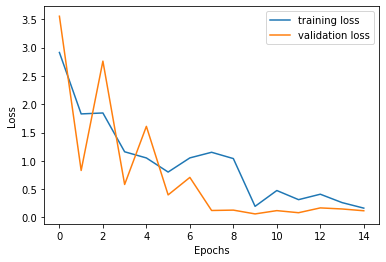

In [58]:
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [59]:
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'

In [61]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/ANN_Test/"

100.0% Confidence This Is No, Its not a tumor


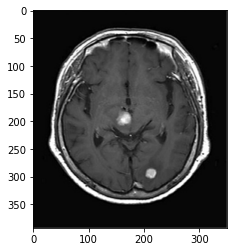

In [63]:
import keras
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
img = Image.open('/content/drive/MyDrive/ANN_Test/brain_tumor_dataset/no/N17.jpg')
x = np.array(img.resize((125,125)))
x = x.reshape(1,125,125,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is ' + names(classification))

99.2713987827301% Confidence This Is A No, Its not a tumor


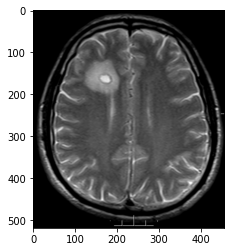

In [64]:
from matplotlib.pyplot import imshow
img = Image.open('/content/drive/MyDrive/ANN_Test/brain_tumor_dataset/yes/Y3.jpg')
x = np.array(img.resize((125,125)))
x = x.reshape(1,125,125,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is A ' + names(classification))

Data Analysis

In [65]:
import glob
from tensorflow.keras.models import Sequential

In [66]:
image1=glob.glob("/content/drive/MyDrive/ANN_Test/brain_tumor_dataset/*/*.JPG")
image2=glob.glob("/content/drive/MyDrive/ANN_Test/brain_tumor_dataset/*/*.jpg")
image=image1+image2
print("Total Number of images:",len(image))

image=pd.Series(image)

Total Number of images: 245


In [67]:
df=pd.DataFrame()
df['filename']=image.map(lambda img_name:img_name.split("/")[-1])
df["ClassID"]=image.map(lambda img_name:img_name.split("/")[-2])
df.head()

,filename,ClassID
0,N1.JPG,no
1,N19.JPG,no
2,N2.JPG,no
3,N26.JPG,no
4,N20.JPG,no


In [68]:
df['ClassID'].value_counts()

yes    154
no      91
Name: ClassID, dtype: int64

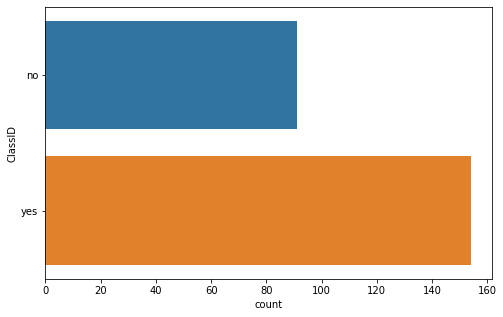

In [69]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.countplot(y=df['ClassID'])
plt.show()

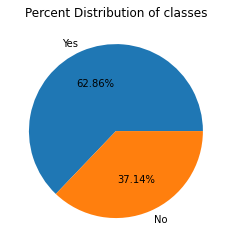

In [70]:
plt.pie(df["ClassID"].value_counts(),labels=['Yes','No'],autopct='%0.2f%%')
plt.title("Percent Distribution of classes")
plt.show()